# Conditional Autoencoder (3 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет

Как вы уже догадались, здесь мы будем использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/)

Если он вам очень не нравится, можете загуглить любой другой, в котором будет четкое разделение картинок по классам.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image

from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)
num_classes = y_test_cat.shape[1]


batch_size = 500
epoch = 250
latent_dim = 32
dropout_rate = 0.3
lr = 0.001

Using TensorFlow backend.


In [0]:
# fix randoms

rnd = 383

import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES']='-1'
os.environ['TF_CUDNN_USE_AUTOTUNE'] ='0'
from numpy.random import seed
import random
random.seed(rnd)
seed(rnd)
from tensorflow import set_random_seed
set_random_seed(rnd)

In [0]:
# Функция отрисовки цифр

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

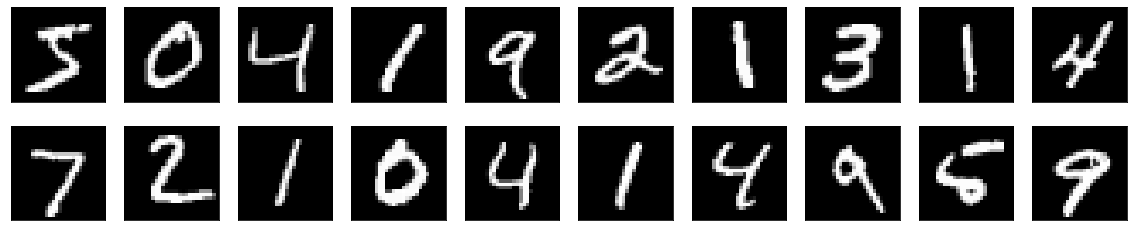

In [4]:
n = 10

tra = x_train[:n]
tes = x_test[:n]


plot_digits(tra, tes)

In [5]:
y_test_cat[0], y_test_cat.shape

(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32), (10000, 10))

In [6]:
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.layers import concatenate
from keras.models import Model
from keras.optimizers import Adam                      # , RMSprop
from keras.objectives import binary_crossentropy
# from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.callbacks import EarlyStopping


def create_cae():

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flatten_img = Flatten()(input_img)
    input_lbl = Input(shape=(num_classes,), dtype='float32')

    x = concatenate([flatten_img, input_lbl])
    x = Dense(256, activation='elu')(x)
    x = apply_bn_and_dropout(x)
    code = Dense(latent_dim, activation='linear')(x)
    
    input_code = Input(shape=(latent_dim,))
    input_lbl_dec = Input(shape=(num_classes,), dtype='float32')
    full_code = concatenate([input_code, input_lbl_dec])
    x = Dense(256, activation='elu')(full_code)

    x = apply_bn_and_dropout(x)
    x = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(x)

    # Модели
    encoder = Model([input_img, input_lbl], code, name="encoder")
    decoder = Model([input_code, input_lbl_dec], decoded, name="decoder")
    autoencoder = Model([input_img, input_lbl],
                        decoder([encoder([input_img, input_lbl]), input_lbl]), name="autoencoder")
    
    return encoder, decoder, autoencoder

c_encoder, c_decoder, c_autoencoder = create_cae()
c_autoencoder.compile(optimizer=Adam(lr), loss=binary_crossentropy, metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
history = c_autoencoder.fit([x_train, y_train_cat], x_train, shuffle=True, epochs=epoch,
                            batch_size=batch_size,
                            validation_data=([x_test, y_test_cat], x_test),
                            verbose=1,
                            callbacks = [EarlyStopping(patience = 5)])




Train on 60000 samples, validate on 10000 samples
Epoch 1/250





60000/60000 [==============================] - 7s 117us/step - loss: 0.4624 - acc: 0.6596 - val_loss: 0.1655 - val_acc: 0.8089
Epoch 2/250
60000/60000 [==============================] - 6s 102us/step - loss: 0.1495 - acc: 0.8096 - val_loss: 0.1124 - val_acc: 0.8120
Epoch 3/250
60000/60000 [==============================] - 6s 101us/step - loss: 0.1252 - acc: 0.8112 - val_loss: 0.1020 - val_acc: 0.8127
Epoch 4/250
60000/60000 [==============================] - 6s 101us/step - loss: 0.1181 - acc: 0.8117 - val_loss: 0.0975 - val_acc: 0.8130
Epoch 5/250
60000/60000 [==============================] - 6s 100us/step - loss: 0.1150 - acc: 0.8119 - val_loss: 0.0953 - val_acc: 0.8131
Epoch 6/250
60000/60000 [==============================] - 6s 100us/step - loss: 0.1131 - acc: 0.8121 - val_loss: 0.0941 - val_acc: 0.8131
Epoch 7/250
60000/60000 [==============================] - 6s 102us/step - loss: 0.1117 - acc: 0.8122 - val_

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


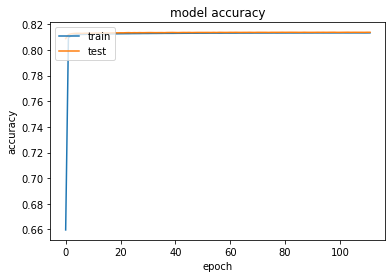

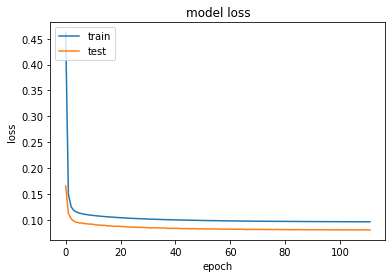

In [8]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

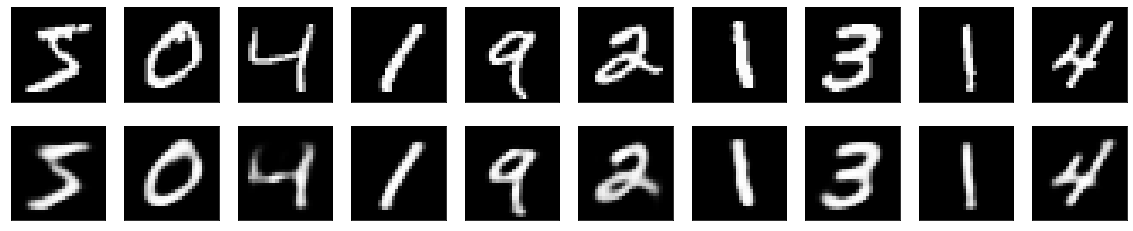

In [9]:
n = 10
imgs = x_train[:n]

c_ae_gen_imgs = c_autoencoder.predict([imgs, y_train_cat[:n]], batch_size=n)

plot_digits(imgs, c_ae_gen_imgs)

(10, 32) (32,)


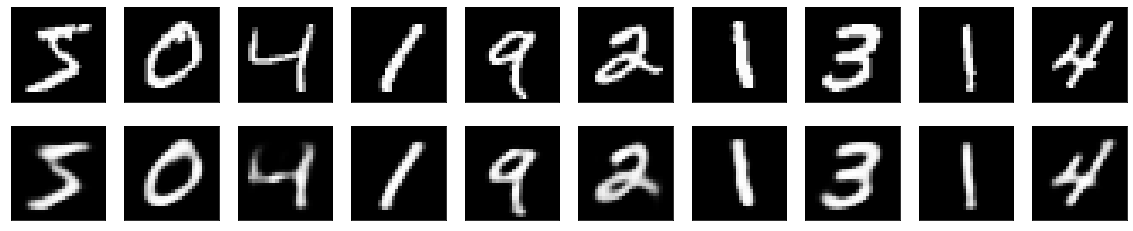

In [10]:
n = 10
imgs = x_train[:n]

encoded_imgs = c_encoder.predict([imgs, y_train_cat[:n]], batch_size=n)
latent_space = encoded_imgs
print(latent_space.shape, latent_space[7].shape)
decoded_imgs = c_decoder.predict([encoded_imgs, y_train_cat[:n]], batch_size=n)

plot_digits(imgs, decoded_imgs)

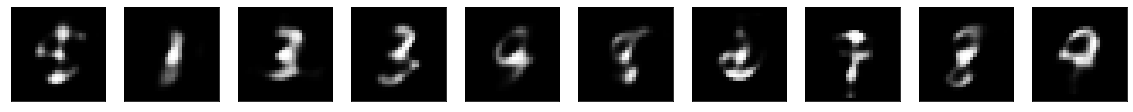

In [11]:
# сгенерируем n рандомных векторов размера latent_dim
# результат плох: пространство цифр очень небольшое, и мало случайных векторов оказываются в нём

n = 10
z = np.random.randn(n, latent_dim)
output = c_decoder.predict([z, np.eye(n,10)])
for i in range(n//10):
    plot_digits(output[i*10:(i*10)+10])

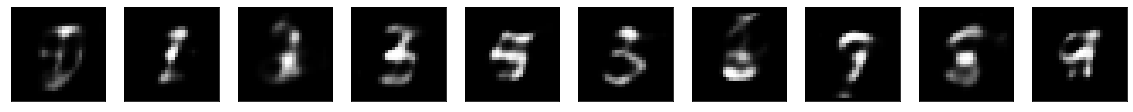

In [12]:
zz = np.array([np.random.normal(0, 1, latent_dim) for i in range(n)])

output = c_decoder.predict([zz, np.eye(n,10)])
for i in range(n//10):
    plot_digits(output[i*10:(i*10)+10])

## Sampling


In [0]:
# получим latent_space со всего датасета

latent_space = c_encoder.predict([x_train, y_train_cat], batch_size=n)

In [14]:
latent_space.shape, latent_space.mean(axis=0).shape, y_train.shape, np.unique(y_train)

((60000, 32),
 (32,),
 (60000,),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

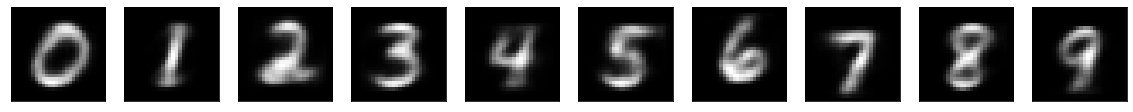

In [15]:
# сгенерируем 10 цифр из latent_space.mean(axis=0)

digits_from_latent = np.array([latent_space.mean(axis=0)]*10)
output = c_decoder.predict([digits_from_latent, np.eye(10,10)])
plot_digits(output)

Splendid! Вы великолепны!

Теперь давайте сделаем следующее: посмотрим на то, как выглядит латентное пространство векторов, соответствующих нашим картинкам. 
Для этого вам нужно:
1.  прогнать картинки из датасета через encoder, получить латентные векторы
2. Прогнать векторы через TSNE, получить их двумерную проекцию
3. Изобразить полученные после TSNE двумерные векторы на плоскости с помощью plt.scatter, покрасив точки в цвета в зависимости от класса картинки, которой она соответствует. (как красить точки, см. в документации к plt.scatter). 
4. Подумать, что вы видите и записать свои мысли

In [16]:
from sklearn.manifold import TSNE
latent_embedded = TSNE(n_components=2).fit_transform(latent_space)

latent_embedded.shape

(60000, 2)

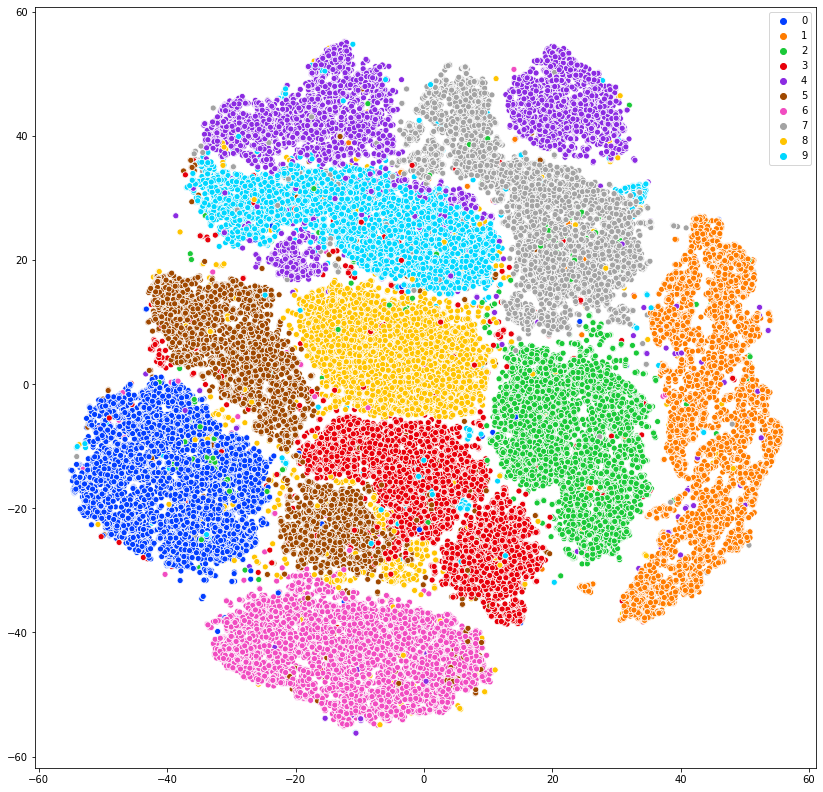

In [17]:
import seaborn as sns

plt.figure(figsize=(14, 14))
sns.scatterplot(x=latent_embedded[:, 1], y=latent_embedded[:, 0],
                hue=y_train, palette=sns.color_palette("bright", 10));

1. Похожие в написании цифры, возможно, кучкуются. Например, голубая 9 + фиолетовая 4, жёлтая 8 + тёмно-коричневая 5 + красная 3, розовая 6 и синий 0. В то же время, такие похожие в написании цифры как 1, 7 и 4 разделены совершенно.
2. Некоторые цифры здорово различны в написании. Так, 5 оказалась окружена 8, расположилась по обе стороны 3 и разделена 9.
3. Между кластерами -- разрывы, внутри кластеров есть вкрапления других классов, иногда, удивительных. Наверное можно предположить, если брать из латентного пространства векторы для декодирования наугад, можно получить и шум, и изрядно кривую цифру, и другую цифру. Я усреднил значения латентного пространства, вышло очень похоже, но не очень чётко.
4. Кластеризация с пом t-sne очень наглядна.